In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36215")
client

<Client: 'tcp://127.0.0.1:36215' processes=8 threads=32, memory=123.94 GiB>

In [2]:
import s3fs
import boto3
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
###
import numba
import matplotlib.path as mpath
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Functions 

In [3]:
def odi_map_stretch(n,xmin_map=-165,xmax_map=-125,ymin_map=67.5,ymax_map=80):
    aoi = mpath.Path(
    list(zip(np.linspace(xmin_map,xmax_map, n), np.full(n,ymax_map))) + \
    list(zip(np.full(n,xmax_map), np.linspace(ymax_map,ymin_map, n))) + \
    list(zip(np.linspace(xmax_map,xmin_map, n), np.full(n,ymin_map))) + \
    list(zip(np.full(n,xmin_map), np.linspace(ymin_map,ymax_map, n))))
    return aoi

# Region of interest

In [4]:
lon0=-150
lonmapmin=-180#-160
lonmapmax=-120#-140
latmapmin=65#69
latmapmax=80#75

# Needed path to be used

In [5]:
salt_path   = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SALT_AVG_DAILY.ZARR/'
siarea_path = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SIarea_AVG_DAILY.ZARR/'
theta_path  = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/THETA_AVG_DAILY.ZARR/'

# Acessing data through AWS - profile = sassie

In [6]:
def get_aws_credentials(profile_name='sassie'):
    session = boto3.Session(profile_name=profile_name)
    credentials = session.get_credentials()
    return credentials
#-----------------------------------------------------
# load sassie profile credentials
aws_credentials = get_aws_credentials(profile_name='sassie')
# initialize s3 filesystem
s3_options = dict(anon=False, key=aws_credentials.access_key, secret=aws_credentials.secret_key)
#------------------------------------------------------
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

# Open SALT zarr store

In [7]:
# open SALT zarr store
SALT_zarr = open_zarr_store(salt_path, s3_options)
SALT_zarr

<xarray.Dataset> Size: 4TB
Dimensions:    (time: 2581, k: 90, j: 1080, i: 1800, k_l: 90, k_p1: 91,
                k_u: 90, nv: 2)
Coordinates: (12/14)
    XC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    Z          (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zl         (k_l) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zp1        (k_p1) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    Zu         (k_u) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    ...         ...
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB dask.array<chunksize=(2581, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT       (time, k, j, i) float64 4TB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:                   Grid
    comment:                         SASSIE llc1080 V1R1 fields are consolida...
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides data variable and ...
    time_coverage_end:               2021-02-08T00:00:00
    time_coverage_start:             2014-01-15T00:00:00
    title:                           SASSIE Ocean Model SALT Parameter for th...
    uuid:                            ee3d4cde-1381-11ef-9c99-0604868e061f

In [8]:
#-> ECCO model time for the data at hand
ecco_time = SALT_zarr.time

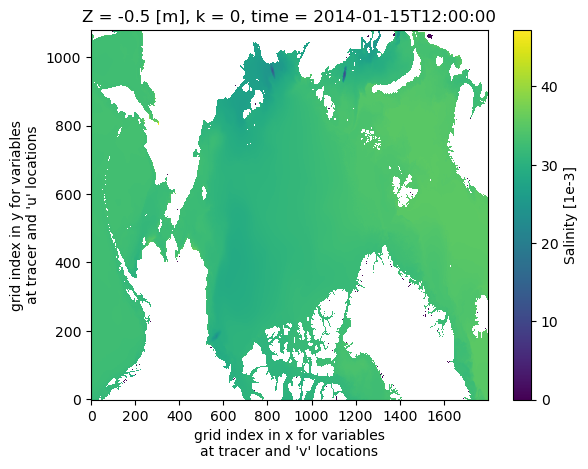

In [9]:
SALT_zarr.SALT[0,0,:,:].plot()

In [10]:
# geom = "s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.ZARR/"
# geom_zarr = open_zarr_store(geom, s3_options)
# # geom_zarr

# Region selection

In [11]:
# Geo area selection
lon_xc = SALT_zarr.XC.values;lat_yc = SALT_zarr.YC.values
geotest = (lon_xc >= lonmapmin) & (lon_xc <= lonmapmax) & (lat_yc >= latmapmin) & (lat_yc <= latmapmax)
geoindex = np.argwhere(geotest)
# Get indexes
xmin = min(geoindex[:,1]);xmax = max(geoindex[:,1])
ymin = min(geoindex[:,0]);ymax = max(geoindex[:,0])
# simple indexes manip.
iid = slice(xmin,xmax);jid = slice(ymin,ymax)
# lon and lad true values in the area of interest
Lon = lon_xc[jid,iid];Lat = lat_yc[jid,iid]

### Fast look on salinity

In [12]:
# sal = SALT_zarr.SALT[0,0,:,:]
# sal[jid,iid].plot(cmap='jet')
# plt.grid(alpha=0.5)

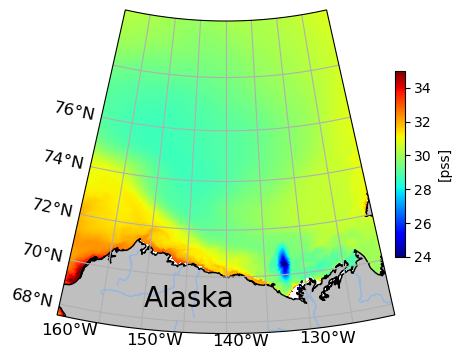

In [13]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
sal = SALT_zarr.SALT[0,0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,sal,cmap='jet',vmin=24,vmax=35,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[pss]')

# Open SIarea zarr store

In [14]:
# open SIarea zarr store
SIarea_zarr = open_zarr_store(siarea_path, s3_options)
SIarea_zarr

<xarray.Dataset> Size: 40GB
Dimensions:    (time: 2581, j: 1080, i: 1800, nv: 2)
Coordinates:
    XC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
  * i          (i) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * j          (j) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB dask.array<chunksize=(2581, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SIarea     (time, j, i) float64 40GB dask.array<chunksize=(1, 270, 450), meta=np.ndarray>
Attributes: (12/50)
    Conventions:               CF-1.8, ACDD-1.3
    acknowledgement:           This research was carried out by the Jet Propu...
    author:                    Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:             Grid
    comment:                   SASSIE llc1080 V1R1 fields are consolidated on...
    creator_email:             ecco-group@mit.edu
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset provides data variable and geomet...
    time_coverage_end:         2021-02-08T00:00:00
    time_coverage_start:       2014-01-15T00:00:00
    title:                     SASSIE Ocean Model SIarea Parameter for the La...
    uuid:                      38daf79a-12d4-11ef-becf-0604868e061f

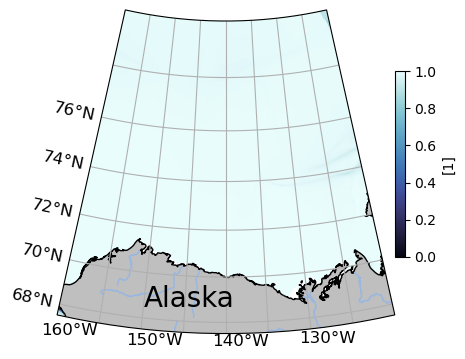

In [15]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
sic = SIarea_zarr.SIarea[0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,sic,cmap='cmo.ice',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[1]')

# Open THETA zarr store

In [16]:
# open THETA zarr store
theta_zarr = open_zarr_store(theta_path, s3_options)
theta_zarr

<xarray.Dataset> Size: 4TB
Dimensions:    (time: 2581, k: 90, j: 1080, i: 1800, k_l: 90, k_p1: 91,
                k_u: 90, nv: 2)
Coordinates: (12/14)
    XC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    Z          (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zl         (k_l) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zp1        (k_p1) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    Zu         (k_u) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    ...         ...
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB dask.array<chunksize=(2581, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    THETA      (time, k, j, i) float64 4TB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:                   Grid
    comment:                         SASSIE llc1080 V1R1 fields are consolida...
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides data variable and ...
    time_coverage_end:               2021-02-08T00:00:00
    time_coverage_start:             2014-01-15T00:00:00
    title:                           SASSIE Ocean Model THETA Parameter for t...
    uuid:                            92f116d8-13ba-11ef-9cf8-0604868e061f

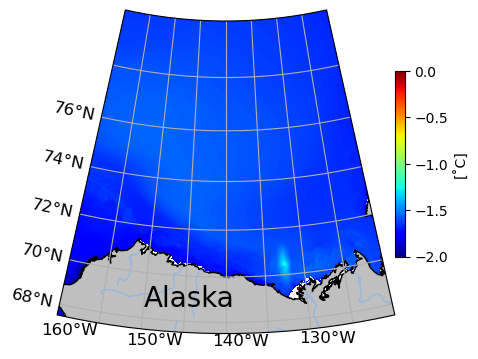

In [23]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
temp = theta_zarr.THETA[0,0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,temp,cmap='jet',vmin=-2,vmax=0,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[˚C]')

# Getting variable in the area of interest

In [18]:
# #-> salinity
# sal_intt  = SALT_zarr.SALT.values[:,:,jid,iid]
# #-> potential temperature
# temp_intt = theta_zarr.THETA.values[:,:,jid,iid]

# -> sea ice concentration [1]

In [19]:
# sic_intt  = SIarea_zarr.SIarea.values[:,jid,iid]

In [20]:
# help(np.datetime64)

In [21]:
# np.where(ecco_time<)

In [22]:
# ecco_time

# Computing the sea ice formation date map for the fall-winter of 2014